# 1st-order elastic with a sinusoid hill

In this notebook, the imposition of an immersed elastic free-surface is shown, using the commonly-used 1st-order formulation of the elastic wave equation. However, it is found that the usual staggered discretization outlined in Vireaux 1984 is not conductive to stability in combination with the immersed boundary treatment. As such, an approach is borrowed from meteorology, by which fields are not staggered, with the even-odd decoupling (also known as checkerboard error) suppressed through the use of wavenumber filters.

This enables the immersed boundary treatment to be used to impose a curvilinear surface with these equations.

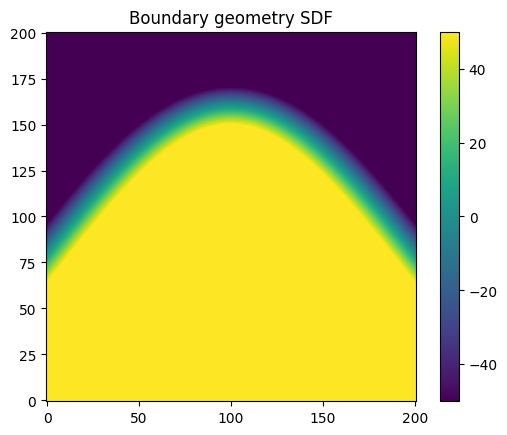

In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

def read_sdf(surface, dims):
    """Unpickle an sdf"""
    fname = '../tests/sdfs/' + surface + '_' + str(dims) + 'd.dat'
    with open(fname, 'rb') as f:
        sdf = pickle.load(f)
    return sdf

# Load the sinusoid 2D sdf
sdf = read_sdf('sinusoid_new_hi_res', 2)

plt.imshow(sdf.data.T, origin='lower')
plt.title("Boundary geometry SDF")
plt.colorbar()
plt.show()

In [2]:
from schism import BoundaryGeometry
import sympy as sp

x, y = sdf.grid.dimensions
zero = sp.core.numbers.Zero()
# Override the cutoff
cutoff = {(zero, zero): 0.}

bg = BoundaryGeometry(sdf)  # , cutoff=cutoff)
grid = bg.grid  # Gets the grid from the signed distance function

Operator `normals` ran in 0.01 s


We will want to define fields for particle velocity and the stress tensor. We will also define some material parameters used in the boundary conditions.

In [3]:
import devito as dv

s_o = 4
tau = dv.TensorTimeFunction(name='tau', grid=grid, space_order=s_o,
                            time_order=1, staggered=((None, None),
                                                     (None, None)))
v = dv.VectorTimeFunction(name='v', grid=grid, space_order=s_o,
                          time_order=1, staggered=(None, None))

# Material parameters
rho = 1.
v_p = 1.
v_s = 0.65

mu = rho*v_s**2
lam = rho*v_p**2 - 2*mu

Now to define the elastic free surface. This condition corresponds to the dot product of the stress tensor and the normal equalling zero.

In [4]:
from schism import BoundaryConditions

nx = bg.n[0]
ny = bg.n[1]

txx = tau[0, 0]
tyy = tau[1, 1]
txy = tau[0, 1]

vx = v[0]
vy = v[1]

# bc_list = [dv.Eq(nx*txx + ny*txy, 0),  # Zeroth-order stress BCs
#            dv.Eq(nx*txy + ny*tyy, 0),
#            dv.Eq(ny*mu*txx.dxdy + nx*(lam+2*mu)*txx.dx2
#                  + nx*(2*lam+2*mu)*txy.dxdy + ny*mu*txy.dx2
#                  + ny*mu*txy.dy2 + ny*mu*tyy.dxdy
#                  + nx*lam*tyy.dy2, 0),  # 2nd-order stress BCs
#            dv.Eq(nx*mu*txx.dxdy + ny*lam*txx.dx2
#                  + ny*(2*lam+2*mu)*txy.dxdy + nx*mu*txy.dx2
#                  + nx*mu*txy.dy2 + nx*mu*tyy.dxdy
#                  + ny*(lam+2*mu)*tyy.dy2, 0),
#            dv.Eq(nx*(lam+2*mu)*vx.dx + nx*lam*vy.dy
#                  + ny*mu*vx.dy + ny*mu*vy.dx, 0),  # Velocity BCs
#            dv.Eq(nx*mu*vx.dy + nx*mu*vy.dx
#                  + ny*(lam+2*mu)*vy.dy + ny*lam*vx.dx, 0)]

bc_list = [dv.Eq(nx*txx + ny*txy, 0),  # Zeroth-order stress BCs
           dv.Eq(nx*txy + ny*tyy, 0),
           dv.Eq(ny*mu*txx.dxdy + nx*(lam+2*mu)*txx.dx2
                 + nx*(2*lam+2*mu)*txy.dxdy + ny*mu*txy.dx2
                 + ny*mu*txy.dy2 + ny*mu*tyy.dxdy
                 + nx*lam*tyy.dy2, 0),  # 2nd-order stress BCs
           dv.Eq(nx*mu*txx.dxdy + ny*lam*txx.dx2
                 + ny*(2*lam+2*mu)*txy.dxdy + nx*mu*txy.dx2
                 + nx*mu*txy.dy2 + nx*mu*tyy.dxdy
                 + ny*(lam+2*mu)*tyy.dy2, 0),
           dv.Eq(ny*mu**2*txx.dxdy3 + ny*mu**2*txy.dx4 + ny*mu**2*txy.dy4
                 + ny*mu**2*tyy.dx3dy + nx*txx.dx2dy2*(lam**2 + 2*lam*mu + 2*mu**2)
                 + ny*txx.dx3dy*(2*lam*mu + 3*mu**2)
                 + nx*txx.dx4*(lam**2 + 4*lam*mu + 4*mu**2)
                 + ny*txy.dx2dy2*(4*lam*mu + 6*mu**2)
                 + nx*txy.dx3dy*(2*lam**2 + 8*lam*mu + 6*mu**2)
                 + nx*txy.dxdy3*(2*lam**2 + 4*lam*mu + 2*mu**2)
                 + nx*tyy.dx2dy2*(lam**2 + 4*lam*mu + 2*mu**2)
                 + ny*tyy.dxdy3*(2*lam*mu + 3*mu**2)
                 + nx*tyy.dy4*(lam**2 + 2*lam*mu), 0),
           dv.Eq(nx*mu**2*txx.dxdy3 + nx*mu**2*txy.dx4 + nx*mu**2*txy.dy4
                 + nx*mu**2*tyy.dx3dy + ny*txx.dx2dy2*(lam**2 + 4*lam*mu + 2*mu**2)
                 + nx*txx.dx3dy*(2*lam*mu + 3*mu**2) + ny*txx.dx4*(lam**2 + 2*lam*mu)
                 + nx*txy.dx2dy2*(4*lam*mu + 6*mu**2)
                 + ny*txy.dx3dy*(2*lam**2 + 4*lam*mu + 2*mu**2)
                 + ny*txy.dxdy3*(2*lam**2 + 8*lam*mu + 6*mu**2)
                 + ny*tyy.dx2dy2*(lam**2 + 2*lam*mu + 2*mu**2)
                 + nx*tyy.dxdy3*(2*lam*mu + 3*mu**2)
                 + ny*tyy.dy4*(lam**2 + 4*lam*mu + 4*mu**2), 0),
           dv.Eq(nx*(lam+2*mu)*vx.dx + nx*lam*vy.dy
                 + ny*mu*vx.dy + ny*mu*vy.dx, 0),  # Velocity BCs
           dv.Eq(nx*mu*vx.dy + nx*mu*vy.dx
                 + ny*(lam+2*mu)*vy.dy + ny*lam*vx.dx, 0),
           dv.Eq(ny*mu**2*vx.dy3 + ny*mu**2*vy.dx3
                 + ny*vx.dx2dy*(2*lam*mu + 3*mu**2)
                 + nx*vx.dx3*(lam**2 + 4*lam*mu + 4*mu**2)
                 + nx*vx.dxdy2*(lam**2 + 2*lam*mu + 2*mu**2)
                 + nx*vy.dx2dy*(lam**2 + 4*lam*mu + 2*mu**2)
                 + ny*vy.dxdy2*(2*lam*mu + 3*mu**2)
                 + nx*vy.dy3*(lam**2 + 2*lam*mu), 0),
           dv.Eq(nx*mu**2*vx.dy3 + nx*mu**2*vy.dx3
                 + nx*vx.dx2dy*(2*lam*mu + 3*mu**2)
                 + ny*vx.dx3*(lam**2 + 2*lam*mu)
                 + ny*vx.dxdy2*(lam**2 + 4*lam*mu + 2*mu**2)
                 + ny*vy.dx2dy*(lam**2 + 2*lam*mu + 2*mu**2)
                 + nx*vy.dxdy2*(2*lam*mu + 3*mu**2)
                 + ny*vy.dy3*(lam**2 + 4*lam*mu + 4*mu**2), 0)]

bcs = BoundaryConditions(bc_list)

In [5]:
from schism import Boundary

boundary = Boundary(bcs, bg)

In [6]:
txxdx = tau[0, 0].dx
txydx = tau[0, 1].dx
vxdx = v[0].forward.dx
vydx = v[1].forward.dx

txydy = tau[0, 1].dy
tyydy = tau[1, 1].dy
vxdy = v[0].forward.dy
vydy = v[1].forward.dy

derivs = (txxdx, txydx, vxdx, vydx,
          txydy, tyydy, vxdy, vydy)

subs = boundary.substitutions(derivs)

Generating stencils for Derivative(tau_xx(t, x, y), x)


Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s


Generating stencils for Derivative(tau_xy(t, x, y), x)


Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s


Generating stencils for Derivative(v_x(t + dt, x, y), x)


Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s


Generating stencils for Derivative(v_y(t + dt, x, y), x)


Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s


Generating stencils for Derivative(tau_xy(t, x, y), y)


Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s


Generating stencils for Derivative(tau_yy(t, x, y), y)


Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s


Generating stencils for Derivative(v_x(t + dt, x, y), y)


Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s


Generating stencils for Derivative(v_y(t + dt, x, y), y)


Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s


In [48]:
from examples.seismic import TimeAxis, RickerSource

# Reset fields
tau[0, 0].data[:] = 0.
tau[0, 1].data[:] = 0.
tau[1, 1].data[:] = 0.
v[0].data[:] = 0.
v[1].data[:] = 0.

t0 = 0.  # Simulation starts a t=0
tn = 650  # Simulation last 0.5 seconds (500 ms)
dt = 0.5*5/v_p  # Time step from grid spacing

time_range = TimeAxis(start=t0, stop=tn, step=dt)

f0 = 0.016  # Source peak frequency is 6Hz (0.006 kHz)
src = RickerSource(name='src', grid=grid, f0=f0,
                   npoint=1, time_range=time_range)

src.coordinates.data[0, 0] = 500.
src.coordinates.data[0, 1] = 600.

In [49]:
# Various shorthands for clarity
b = 1/rho

# Velocity updates
eq_vx = dv.Eq(v[0].forward, v[0] + dt*b*(subs[txxdx] + subs[txydy]))
eq_vy = dv.Eq(v[1].forward, v[1] + dt*b*(subs[txydx] + subs[tyydy]))

# Normal stress updates
eq_txx = dv.Eq(tau[0, 0].forward, tau[0, 0] + dt*(lam+2*mu)*subs[vxdx] + dt*lam*subs[vydy])
eq_tyy = dv.Eq(tau[1, 1].forward, tau[1, 1] + dt*(lam+2*mu)*subs[vydy] + dt*lam*subs[vxdx])

# Shear stress update
eq_txy = dv.Eq(tau[0, 1].forward, tau[0, 1] + dt*mu*(subs[vxdy] + subs[vydx]))

# # Velocity updates
# eq_vx = dv.Eq(v[0].forward, v[0] + dt*b*(txxdx + txydy))
# eq_vy = dv.Eq(v[1].forward, v[1] + dt*b*(txydx + tyydy))

# # Normal stress updates
# eq_txx = dv.Eq(tau[0, 0].forward, tau[0, 0] + dt*(lam+2*mu)*vxdx + dt*lam*vydy)
# eq_tyy = dv.Eq(tau[1, 1].forward, tau[1, 1] + dt*(lam+2*mu)*vydy + dt*lam*vxdx)

# # Shear stress update
# eq_txy = dv.Eq(tau[0, 1].forward, tau[0, 1] + dt*mu*(vxdy + vydx))

In [50]:
src_txx = src.inject(field=tau[0, 0].forward, expr=src)
src_tyy = src.inject(field=tau[1, 1].forward, expr=src)

In [51]:
# Set up wavenumber filter
def get_filter(f, dim, hs):
    """Return a set of equations to apply the filter"""
    if hs == 4:
        # 8th order
        coeffs = np.array([-1., 8., -28., 56., 186., 56., -28., 8., -1.])/256.
    elif hs == 3:
        # 6th order
        coeffs = np.array([1., -6., 15., 44., 15., -6., 1.])/64.
    elif hs == 2:
        # 4th order
        coeffs = np.array([-1., 4., 10., 4., -1.])/16.
    elif hs == 1:
        coeffs = np.array([1., 2., 1.])/4.
        
    h_dim = dim.spacing
    indices = tuple(range(-hs, 1+hs))
    points = [f.subs(dim, dim+i*h_dim) for i in indices]

    expr = sum(coeff*point for coeff, point in zip(coeffs, points))
    
    # Temporary function to store filtered values
    # NOTE: Could just have one of these and reuse it
    f_temp = dv.Function(name=f.name+'_temp_'+dim.name, grid=f.grid, space_order=0)
    
    # Fill temp with filtered values, then set f to filtered values
    eq_filter = dv.Eq(f_temp, expr)
    eq_set = dv.Eq(f, f_temp)
    
    return [eq_filter, eq_set]

hs = 2
x, y = grid.dimensions

# Filter velocity components
filter_vx_x = get_filter(v[0].forward, x, hs)
filter_vx_y = get_filter(v[0].forward, y, hs)
filter_vy_x = get_filter(v[1].forward, x, hs)
filter_vy_y = get_filter(v[1].forward, y, hs)

# Filter normal stress components
filter_txx_x = get_filter(tau[0, 0].forward, x, hs)
filter_txx_y = get_filter(tau[0, 0].forward, y, hs)
filter_tyy_x = get_filter(tau[1, 1].forward, x, hs)
filter_tyy_y = get_filter(tau[1, 1].forward, y, hs)

# Filter shear stress components
filter_txy_x = get_filter(tau[0, 1].forward, x, hs)
filter_txy_y = get_filter(tau[0, 1].forward, y, hs)

In [52]:
op = dv.Operator([eq_vx, eq_vy]
                 + filter_vx_x + filter_vx_y
                 + filter_vy_x + filter_vy_y
                 + [eq_txx, eq_tyy, eq_txy]
                 + filter_txx_x + filter_txx_y
                 + filter_tyy_x + filter_tyy_y
                 + filter_txy_x + filter_txy_y
                 + src_txx + src_tyy)
op(time=time_range.num-1, dt=dt)

Operator `Kernel` ran in 9.31 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=5.710663000000002, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=0.02768499999999997, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section2', rank=None),
                     PerfEntry(time=0.015071999999999983, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section3', rank=None),
                     PerfEntry(time=3.4526270000000006, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section4', rank=None),
                     PerfEntry(time=0.035458000000000024, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section5', rank=None),
                     PerfEntry(time=0.041491999999999994, gflopss=0.0, gp

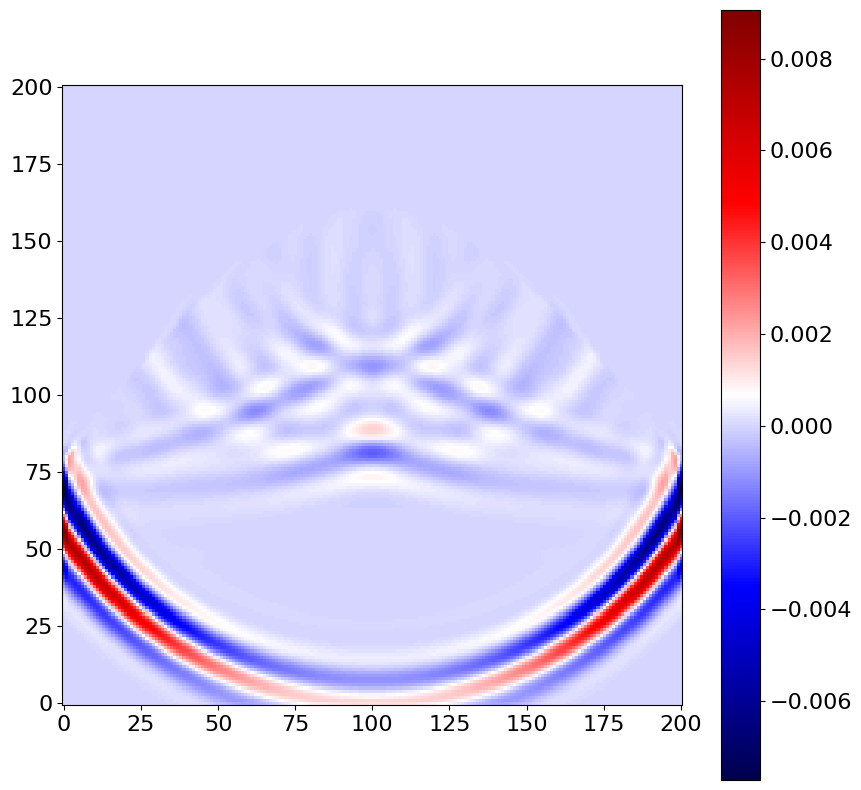

In [53]:
plt.figure(figsize=(10, 10))
plt.imshow(tau[0, 0].data[1].T, origin='lower', cmap='seismic')
plt.colorbar()
plt.show()

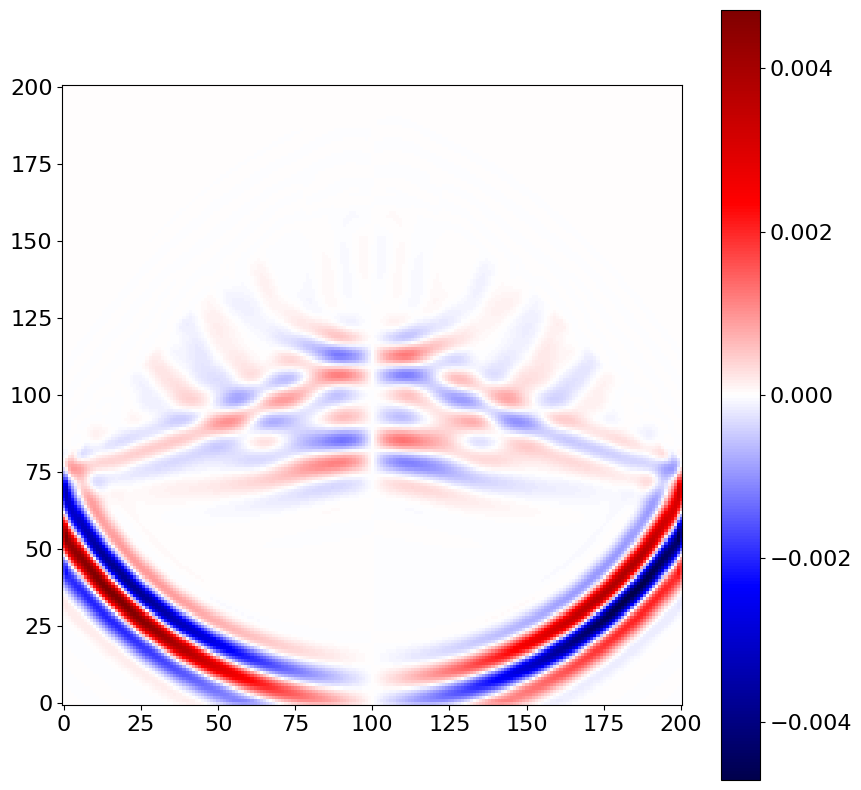

In [54]:
plt.figure(figsize=(10, 10))
plt.imshow(tau[0, 1].data[1].T, origin='lower', cmap='seismic')
plt.colorbar()
plt.show()

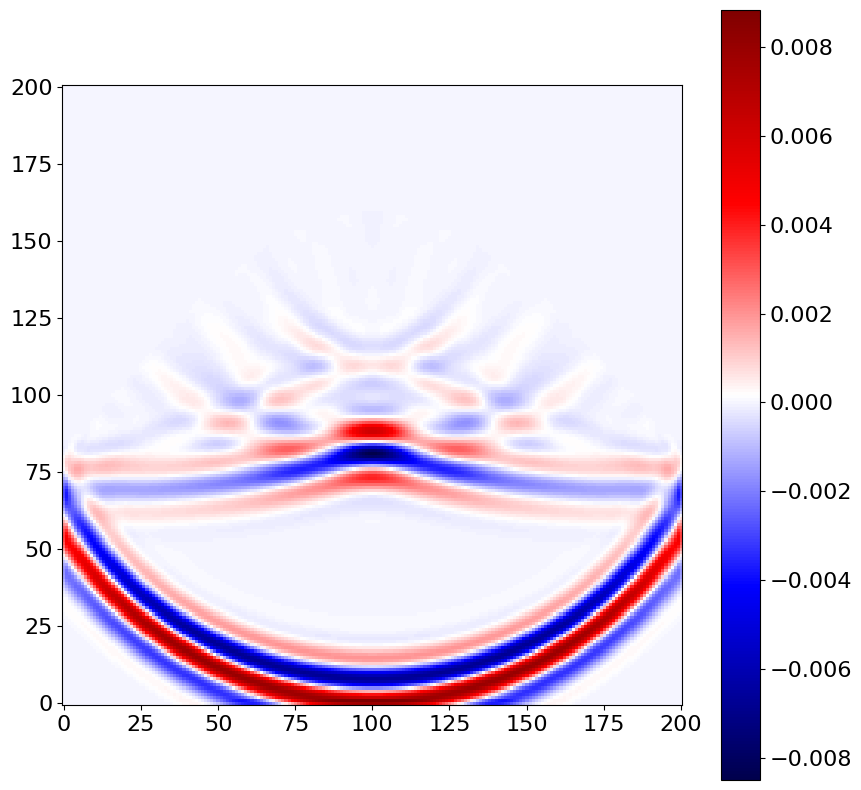

In [55]:
plt.figure(figsize=(10, 10))
plt.imshow(tau[1, 1].data[1].T, origin='lower', cmap='seismic')
plt.colorbar()
plt.show()

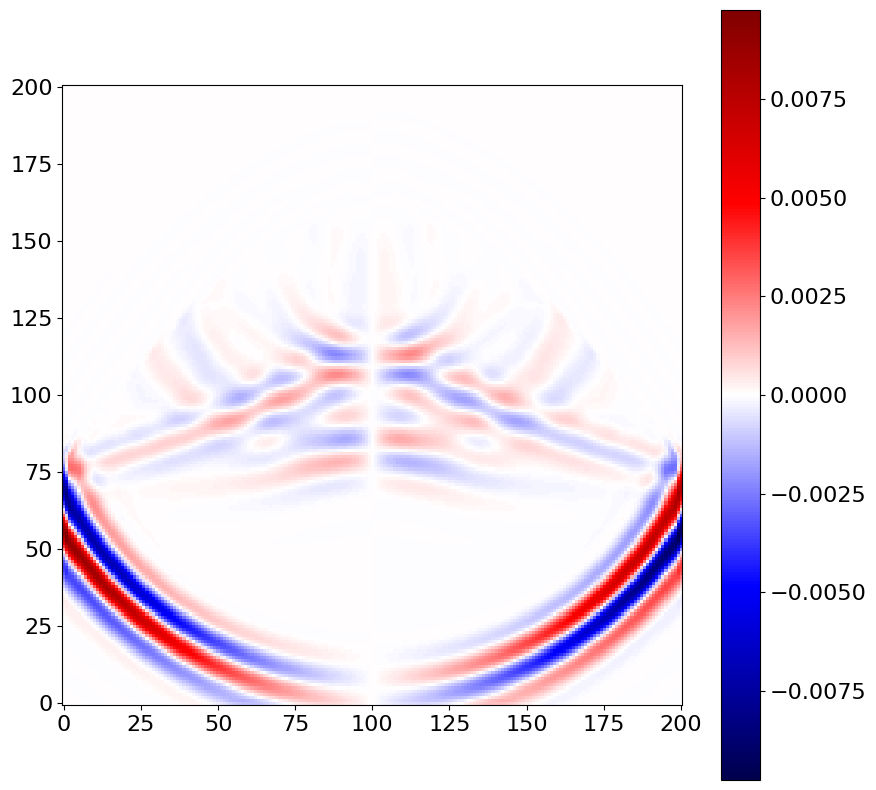

In [56]:
plt.figure(figsize=(10, 10))
plt.imshow(v[0].data[1].T, origin='lower', cmap='seismic')
plt.colorbar()
plt.show()

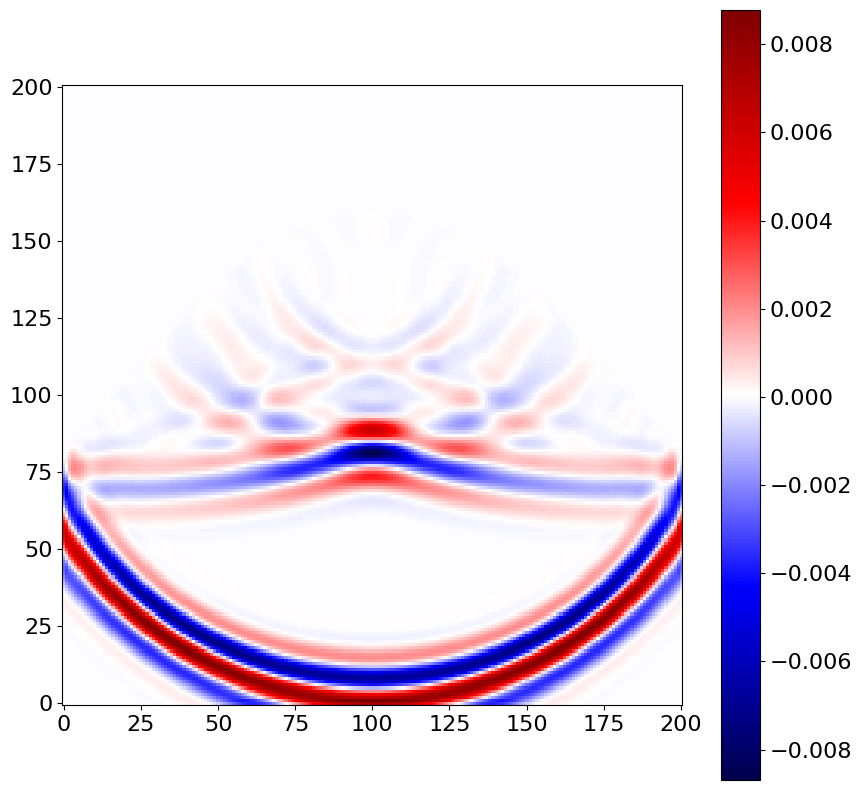

In [57]:
plt.figure(figsize=(10, 10))
plt.imshow(v[1].data[1].T, origin='lower', cmap='seismic')
plt.colorbar()
plt.show()

Note that the reflection off the immersed boundary results in a PS conversion, which is not seen when the wave hits the bottom of the domain.

In [17]:
np.amax(tau[0, 0].data[1])

Data(0.00905748, dtype=float32)